
### **1. Google Drive 마운트**
- 데이터셋 및 모델 체크포인트를 저장/불러오기 위함

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **2. 라이브러리 임포트**

In [ ]:
# 데이터 처리 및 전처리 관련 라이브러리
import numpy as np
import pandas as pd

# 딥러닝 모델링(PyTorch) 및 학습 관련 라이브러리
import torch
import torch.nn as nn

# 시각화 관련 라이브러리
import matplotlib.pyplot as plt

# 유틸리티 함수 및 환경 설정 관련 라이브러리
import random
import os
import json

# Hugging Face 라이브러리
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

# Transformers 관련 라이브러리
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

from torch.nn import BCEWithLogitsLoss

### **3. 랜덤 시드 설정 함수**

In [ ]:
def set_random_seed(seed=42):
    """랜덤 시드 고정 (재현성 확보)"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"랜덤 시드 {seed}로 고정 완료")

### **4. 모델 및 토크나이저 로드 함수**



In [ ]:
def load_model_and_tokenizer(model_name="beomi/KcELECTRA-base-v2022", num_labels=1):
    """모델 및 토크나이저 로드"""
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)  # WordPiece 토크나이저 (OOV 대응 위해 use_fast=False 유지)

    # 이진 분류 모델
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,  # BCE Loss 사용을 위해 출력 차원을 1로 설정
    )

    print(f"모델 및 토크나이저 로드 완료: {model_name}")
    return model, tokenizer

### **6. 모델 레이어 동결 함수**

In [ ]:
def freeze_model_layers(model, n_layers_to_train=4):
    """
    모델의 특정 레이어 동결

    Args:
        model: ELECTRA 모델
        n_layers_to_train: 학습할 마지막 레이어 개수
    """
    # encoder = model.electra

    # # 1) 임베딩 층 동결 : 사전학습된 언어의 기본 표현(단어 임베딩) 보존
    # for param in encoder.embeddings.parameters():
    #     param.requires_grad = False

    # # 2) 인코더 레이어 중 마지막 4개 레이어만 학습
    # encoder_layers = encoder.encoder.layer
    # n_frozen = len(encoder_layers) - n_layers_to_train

    # # 처음부터 n_frozen개 레이어까지 동결
    # for layer in encoder_layers[:n_frozen]:
    #     for param in layer.parameters():
    #         param.requires_grad = False

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_params = sum(p.numel() for p in model.parameters())
    print(f"전체 파라미터 수: {all_params:,}")
    print(f"학습되는 파라미터 수: {trainable_params:,}")

    return model

### **7. 커스텀 Trainer 클래스 및 평가 지표 함수**

In [ ]:
# CustomTrainer 클래스 정의 (BCE Loss 사용)
class MyTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Trainer에서 이진 분류용 손실을 계산하기 위해 재정의한 함수

        Args:
            model: 학습할 모델
            inputs: 입력 데이터 배치 (input_ids, attention_mask, labels 포함)
            return_outputs: 출력도 함께 반환할지 여부
            num_items_in_batch: 배치 크기
        Returns:
            loss: 손실 값
            (loss, outputs): return_outputs=True인 경우
        """
        labels = inputs.pop("labels").float()
        outputs = model(**inputs)
        logits = outputs.logits.squeeze(-1)   # (batch, 1) → (batch,)

        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
def compute_metrics(eval_pred):
    """평가 지표 계산 함수"""
    logits, labels = eval_pred
    # Sigmoid를 적용하여 확률로 변환
    probs = 1 / (1 + np.exp(-logits.squeeze(-1)))
    # 이진 분류
    preds = (probs > 0.5).astype(int)
    return {"accuracy": np.mean(preds == labels)}

### **8. 학습 설정 및 학습 함수**

In [ ]:
def create_training_args(output_dir, learning_rate=5e-5, batch_size=32, num_epochs=10):
    """
    훈련 인자 설정

    Args:
        output_dir: 결과 저장 디렉토리
        learning_rate: 학습률
        batch_size: 배치 크기
        num_epochs: 훈련 에폭 수

    Returns:
        TrainingArguments 객체
    """
    training_args = TrainingArguments(
        output_dir=output_dir,  # 결과 저장 디렉토리
        learning_rate=learning_rate,  # 학습률
        per_device_train_batch_size=batch_size,  # 훈련 배치 크기
        per_device_eval_batch_size=batch_size,  # 평가 배치 크기
        num_train_epochs=num_epochs,  # 훈련 에폭 수
        weight_decay=0.01,  # 가중치 감소
        eval_strategy="steps",  # 에폭마다 평가 수행
        eval_steps=10,  # 10 스텝마다 평가
        save_strategy="steps",  # 에폭마다 모델 저장
        save_steps=10,  # 10 스텝마다 체크포인트 저장
        load_best_model_at_end=True,  # 훈련 종료 시 가장 좋은 모델 로드
        metric_for_best_model="accuracy",  # 가장 좋은 모델을 선택하기 위한 메트릭
        push_to_hub=False,  # Hugging Face Hub에 모델 업로드 여부
        report_to="none",  # 외부 로깅 도구 사용 안 함
        logging_steps=10,  # 10 스텝마다 로그 기록
        seed=42,  # 랜덤 시드: 42
        data_seed=42  # 데이터 셔플 시드: 42
    )

    return training_args

In [ ]:
def train_model(model, training_args, tokenized_datasets):
    """
    모델 학습

    Args:
        model: 학습할 모델
        training_args: 훈련 설정
        tokenized_datasets: 토크나이징된 데이터셋

    Returns:
        trainer 객체
    """
    # Trainer 객체 생성
    trainer = MyTrainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=3,  # 3번 연속 개선 없으면 조기 종료
                early_stopping_threshold=0.0
            )
        ],
    )

    # 훈련 시작
    trainer.train()

    return trainer

### **9. 학습 히스토리 추출 및 분석 함수**

In [ ]:
def extract_training_history(trainer):
    """
    학습 과정에서 기록된 loss, accuracy 추출

    Args:
        trainer: Trainer 객체

    Returns:
        train_losses, eval_losses, eval_accs, eval_steps, train_steps
    """
    train_losses = []
    eval_losses = []
    eval_accs = []
    eval_steps = []

    for log in trainer.state.log_history:
        # Train loss 추출
        if 'loss' in log and 'eval_loss' not in log:
            train_losses.append(log['loss'])
        # Validation loss 및 accuracy 추출
        if 'eval_loss' in log:
            eval_steps.append(log['step'])
            eval_losses.append(log['eval_loss'])
            eval_accs.append(log['eval_accuracy'])

    # train_steps 생성 (eval_steps와 동일하게)
    train_steps = eval_steps[:len(train_losses)]

    return train_losses, eval_losses, eval_accs, eval_steps, train_steps

In [ ]:
def compute_train_accuracy_per_checkpoint(eval_steps, training_args, tokenized_datasets):
    """
    각 평가 스텝마다 저장된 체크포인트의 Train Accuracy 계산

    Args:
        eval_steps: 평가가 수행된 스텝 리스트
        training_args: 훈련 설정
        tokenized_datasets: 토크나이징된 데이터셋

    Returns:
        train_accs 리스트
    """
    train_accs = []

    # 각 평가 스텝마다 저장된 체크포인트 불러오기
    for step in eval_steps:
        checkpoint_path = os.path.join(training_args.output_dir, f"checkpoint-{step}")

        print(f"Step {step} 처리 중...", end=" ")

        if os.path.exists(checkpoint_path):
            # 체크포인트 모델 로드
            temp_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)

            # Trainer 생성
            temp_trainer = MyTrainer(
                model=temp_model,
                args=training_args,
                train_dataset=tokenized_datasets["train"],
                eval_dataset=tokenized_datasets["validation"],
                compute_metrics=compute_metrics,
            )

            # Train dataset으로 평가
            result = temp_trainer.evaluate(tokenized_datasets["train"])
            train_accs.append(result["eval_accuracy"])

            print(f"Train Acc: {result['eval_accuracy']:.4f}")

            # 메모리 정리 (GPU 메모리 부족 방지)
            del temp_model, temp_trainer
            torch.cuda.empty_cache()
        else:
            train_accs.append(None)

    print(f"Train accuracies: {len(train_accs)}개")

    return train_accs

### **10. 시각화 함수**

In [ ]:
def exponential_smoothing(values, weight=0.6):
    """
    Exponential Smoothing(지수평활법) 함수

    Args:
        values: 평활화할 값 리스트
        weight: 이전 값에 대한 가중치

    Returns:
        평활화된 값 리스트
    """
    if len(values) == 0:
        return []
    smoothed = []
    last = values[0]
    for point in values:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [ ]:
def plot_training_results(train_steps, eval_steps, train_losses, eval_losses,
                         train_accs, eval_accs, weight=0.6):
    """
    학습 결과 그래프 그리기

    Args:
        train_steps: 학습 스텝
        eval_steps: 평가 스텝
        train_losses: 학습 Loss
        eval_losses: 검증 Loss
        train_accs: 학습 Accuracy
        eval_accs: 검증 Accuracy
        weight: 지수평활법 가중치
    """
    # Exponential Smoothing 적용
    train_losses_smooth = exponential_smoothing(train_losses, weight=weight)
    eval_losses_smooth = exponential_smoothing(eval_losses, weight=weight)
    eval_accs_smooth = exponential_smoothing(eval_accs, weight=weight)
    train_accs_smooth = exponential_smoothing(train_accs, weight=weight)

    # 그래프 생성
    plt.figure(figsize=(14, 5))

    # (1) Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_steps, train_losses_smooth, marker="o", label="Train Loss",
             linewidth=2, markersize=6, color='blue')
    plt.plot(eval_steps, eval_losses_smooth, marker="o", label="Validation Loss",
             linewidth=2, markersize=6, color='green')
    plt.title("Loss (Train vs Validation)")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.ylim(0, 0.8)
    plt.grid(True, alpha=0.3)
    plt.legend()

    # (2) Accuracy 그래프
    plt.subplot(1, 2, 2)

    if len(train_accs_smooth) > 0:
        plt.plot(eval_steps, train_accs_smooth, marker="o",
                 label="Train Accuracy", linewidth=2, markersize=6, color='blue')

    if len(eval_accs_smooth) > 0:
        plt.plot(eval_steps, eval_accs_smooth, marker="o", label="Validation Accuracy",
                 linewidth=2, markersize=6, color='green')

    plt.title("Accuracy (Train vs Validation)")
    plt.xlabel("Step")
    plt.ylabel("Accuracy")
    plt.ylim(0.8, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

### **11. 모델 평가 함수**

In [ ]:
def evaluate_on_validation(trainer, tokenized_datasets):
    """
    Validation 데이터셋 평가

    Args:
        trainer: Trainer 객체
        tokenized_datasets: 토크나이징된 데이터셋
    """
    validation_dataset = tokenized_datasets["validation"]

    # 전체 평가 수행
    validation_results = trainer.evaluate(validation_dataset)
    print("=== Validation 결과 ===")
    print(validation_results)
    print("Validation Accuracy:", validation_results["eval_accuracy"])

    # 좀 더 자세한 성능 리포트
    # 예측 수행
    pred_output = trainer.predict(validation_dataset)
    logits = pred_output.predictions.squeeze(-1)
    labels = pred_output.label_ids

    # 확률 및 예측값 계산
    probs = 1 / (1 + np.exp(-logits))  # Sigmoid 적용
    preds = (probs > 0.5).astype(int)  # 이진 분류

    # Classification Report
    print("\n=== Classification Report (Validation) ===")
    print(classification_report(
        labels,
        preds,
        target_names=["과장광고(0)", "정상광고(1)"],
        digits=4
    ))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\n=== Confusion Matrix (Validation) ===")
    print(cm)

In [ ]:
def evaluate_on_test(trainer, tokenized_test):
    """
    Test 데이터셋 평가

    Args:
        trainer: Trainer 객체
        tokenized_test: 토크나이징된 테스트 데이터셋
    """
    # 전체 평가 수행
    test_results = trainer.evaluate(tokenized_test)
    print("=== Test 결과 ===")
    print(test_results)
    print("Test Accuracy:", test_results["eval_accuracy"])

    # 좀 더 자세한 성능 리포트
    # 예측 수행
    pred_output = trainer.predict(tokenized_test)
    logits = pred_output.predictions.squeeze(-1)
    labels = pred_output.label_ids

    # 확률 및 예측값 계산
    probs = 1 / (1 + np.exp(-logits))  # Sigmoid 적용
    preds = (probs > 0.5).astype(int)  # 이진 분류

    # Classification Report
    print("\n=== Classification Report (Test) ===")
    print(classification_report(
        labels,
        preds,
        target_names=["과장광고(0)", "정상광고(1)"],
        digits=4
    ))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    print("\n=== Confusion Matrix (Test) ===")
    print(cm)

### **12. Best 모델 로드 함수**

In [ ]:
def find_best_checkpoint(base_path):
    """
    가장 높은 eval_accuracy를 가진 체크포인트 찾기

    Args:
        base_path: 체크포인트들이 저장된 기본 경로

    Returns:
        best_ckpt_path, best_acc
    """
    best_ckpt_path = None
    best_acc = -1.0

    # 모든 체크포인트 폴더 검색
    for ckpt in sorted(os.listdir(base_path)):
        # checkpoint-XXX 폴더만 사용
        if not ckpt.startswith("checkpoint"):
            continue

        ckpt_path = os.path.join(base_path, ckpt)
        state_file = os.path.join(ckpt_path, "trainer_state.json")
        if not os.path.exists(state_file):
            continue

        # trainer_state.json에서 eval_accuracy 읽기
        with open(state_file, "r") as f:
            state = json.load(f)

        logs = state.get("log_history", [])
        eval_logs = [log for log in logs if "eval_accuracy" in log]
        if not eval_logs:
            continue

        # 해당 체크포인트에서 마지막 평가 로그 확인
        last_eval = eval_logs[-1]
        acc = last_eval["eval_accuracy"]

        # 제일 높은 정확도로 업데이트
        if acc > best_acc:
            best_acc = acc
            best_ckpt_path = ckpt_path

    print("BEST checkpoint 경로:", best_ckpt_path)
    print("BEST eval_accuracy:", best_acc)

    return best_ckpt_path, best_acc

In [ ]:
def load_best_model(best_ckpt_path):
    """
    Best checkpoint에서 모델 로드

    Args:
        best_ckpt_path: 최고 성능 체크포인트 경로

    Returns:
        로드된 모델
    """
    best_model = AutoModelForSequenceClassification.from_pretrained(best_ckpt_path)
    print("BEST MODEL 로드 완료")

    return best_model

### **13. 예측 함수**

In [ ]:
def predict(text, model, tokenizer):
    """
    텍스트 예측 함수

    Args:
        text: 입력 텍스트
        model: 예측에 사용할 모델
        tokenizer: 토크나이저

    Returns:
        pred: 예측 라벨 (0 또는 1)
        prob: 정상광고 확률
    """
    # 1) 입력 인코딩
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    )

    # 입력 텐서 GPU로 이동시키기
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # 2) 모델 예측
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits.squeeze(-1)
        prob = torch.sigmoid(logits).item()
        pred = 1 if prob > 0.5 else 0

    # 3) 확률 계산
    normal_prob = prob  # 정상광고 확률
    exaggerated_prob = 1 - prob  # 과장광고 확률

    # 4) 클래스 이름
    label = "정상광고(1)" if pred == 1 else "과장광고(0)"

    print("입력 문장:", text)
    print("예측:", label)
    print("과장광고 확률:", round(exaggerated_prob, 3))
    print("정상광고 확률:", round(normal_prob, 3))

    return pred, prob

### **14. 전처리된 데이터 로드**


In [ ]:
# 전처리된 데이터 로드
import pickle

# Google Drive에서 로드
load_path = '/content/drive/MyDrive/preprocessed_data.pkl'

with open(load_path, 'rb') as f:
    data = pickle.load(f)

tokenized_datasets = data['tokenized_datasets']
tokenized_test = data['tokenized_test']

print("전처리된 데이터 로드 완료!")
print(f"Train 크기: {len(tokenized_datasets['train'])}")
print(f"Validation 크기: {len(tokenized_datasets['validation'])}")
print(f"Test 크기: {len(tokenized_test)}")

전처리된 데이터 로드 완료!
Train 크기: 1744
Validation 크기: 436
Test 크기: 224


### **15. 모델 학습 실행**


랜덤 시드 42로 고정 완료


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 및 토크나이저 로드 완료: beomi/KcELECTRA-base-v2022
전체 파라미터 수: 127,777,537
학습되는 파라미터 수: 127,777,537


Step,Training Loss,Validation Loss,Accuracy
10,0.661300,0.589331,0.853211
20,0.533100,0.402348,0.922018
30,0.428100,0.307188,0.926606
40,0.314600,0.230355,0.933486
50,0.229400,0.196375,0.947248
60,0.177100,0.175935,0.949541
70,0.159800,0.151602,0.947248
80,0.168100,0.136344,0.961009
90,0.125000,0.205024,0.926606
100,0.180500,0.094121,0.967890


Step 10 처리 중... 

Train Acc: 0.8601
Step 20 처리 중... 

Train Acc: 0.9117
Step 30 처리 중... 

Train Acc: 0.9260
Step 40 처리 중... 

Train Acc: 0.9490
Step 50 처리 중... 

Train Acc: 0.9576
Step 60 처리 중... 

Train Acc: 0.9685
Step 70 처리 중... 

Train Acc: 0.9673
Step 80 처리 중... 

Train Acc: 0.9725
Step 90 처리 중... 

Train Acc: 0.9644
Step 100 처리 중... 

Train Acc: 0.9862
Step 110 처리 중... 

Train Acc: 0.9897
Step 120 처리 중... 

Train Acc: 0.9937
Step 130 처리 중... 

Train Acc: 0.9943
Train accuracies: 13개


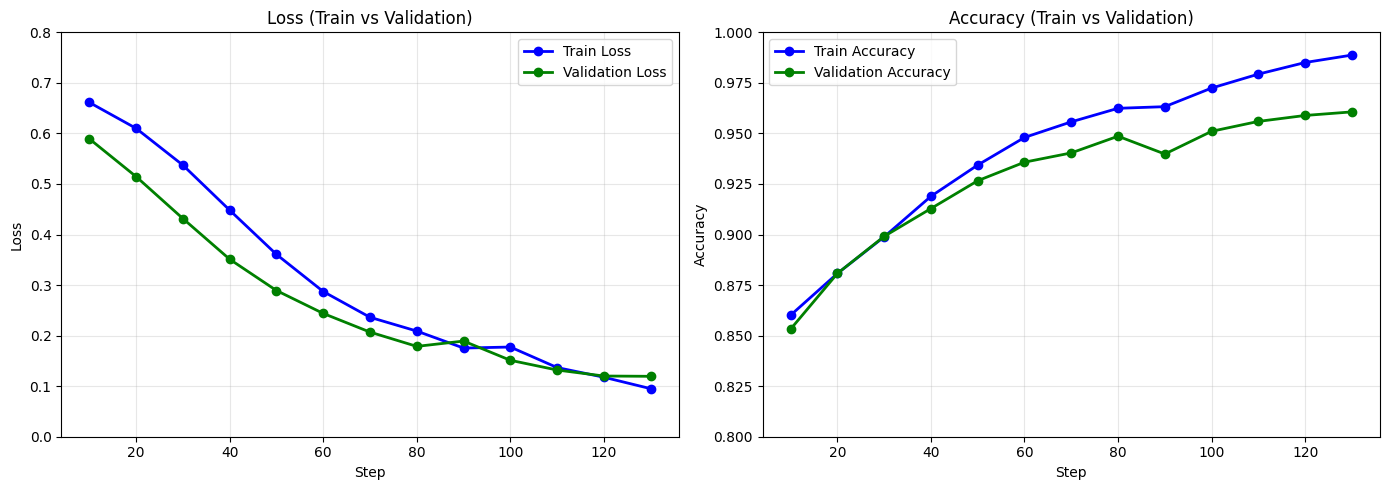

=== Validation 결과 ===
{'eval_loss': 0.09412097185850143, 'eval_accuracy': 0.9678899082568807, 'eval_runtime': 6.8168, 'eval_samples_per_second': 63.96, 'eval_steps_per_second': 2.054, 'epoch': 2.3636363636363638}
Validation Accuracy: 0.9678899082568807

=== Classification Report (Validation) ===
              precision    recall  f1-score   support

     과장광고(0)     0.9679    0.9679    0.9679       218
     정상광고(1)     0.9679    0.9679    0.9679       218

    accuracy                         0.9679       436
   macro avg     0.9679    0.9679    0.9679       436
weighted avg     0.9679    0.9679    0.9679       436


=== Confusion Matrix (Validation) ===
[[211   7]
 [  7 211]]
BEST checkpoint 경로: /content/drive/MyDrive/[learning_rate=3e-5]results/checkpoint-100
BEST eval_accuracy: 0.9678899082568807
BEST MODEL 로드 완료


=== Test 결과 ===
{'eval_loss': 0.17826130986213684, 'eval_model_preparation_time': 0.0024, 'eval_accuracy': 0.9419642857142857, 'eval_runtime': 3.5106, 'eval_samples_per_second': 63.806, 'eval_steps_per_second': 1.994}
Test Accuracy: 0.9419642857142857

=== Classification Report (Test) ===
              precision    recall  f1-score   support

     과장광고(0)     0.9439    0.9352    0.9395       108
     정상광고(1)     0.9402    0.9483    0.9442       116

    accuracy                         0.9420       224
   macro avg     0.9420    0.9417    0.9419       224
weighted avg     0.9420    0.9420    0.9420       224


=== Confusion Matrix (Test) ===
[[101   7]
 [  6 110]]


In [ ]:
# 실행 예시
SEED = 42
set_random_seed(SEED)

# 모델 로드
model, tokenizer = load_model_and_tokenizer()
model = freeze_model_layers(model, n_layers_to_train=4)

# 학습 설정
training_args = create_training_args(
    output_dir="/content/drive/MyDrive/[learning_rate=3e-5]results",
    learning_rate=3e-5,
    batch_size=32,
    num_epochs=10
)

# 모델 학습
trainer = train_model(model, training_args, tokenized_datasets)

# 학습 히스토리 추출
train_losses, eval_losses, eval_accs, eval_steps, train_steps = extract_training_history(trainer)
train_accs = compute_train_accuracy_per_checkpoint(eval_steps, training_args, tokenized_datasets)

# 시각화
plot_training_results(train_steps, eval_steps, train_losses, eval_losses,
                     train_accs, eval_accs, weight=0.6)

# Validation 평가
evaluate_on_validation(trainer, tokenized_datasets)

# Best 모델 로드 및 Test 평가
best_ckpt_path, best_acc = find_best_checkpoint(training_args.output_dir)
best_model = load_best_model(best_ckpt_path)
best_trainer = MyTrainer(
    model=best_model,
    args=training_args,
    compute_metrics=compute_metrics,
    eval_dataset=tokenized_datasets["validation"],
)
evaluate_on_test(best_trainer, tokenized_test)